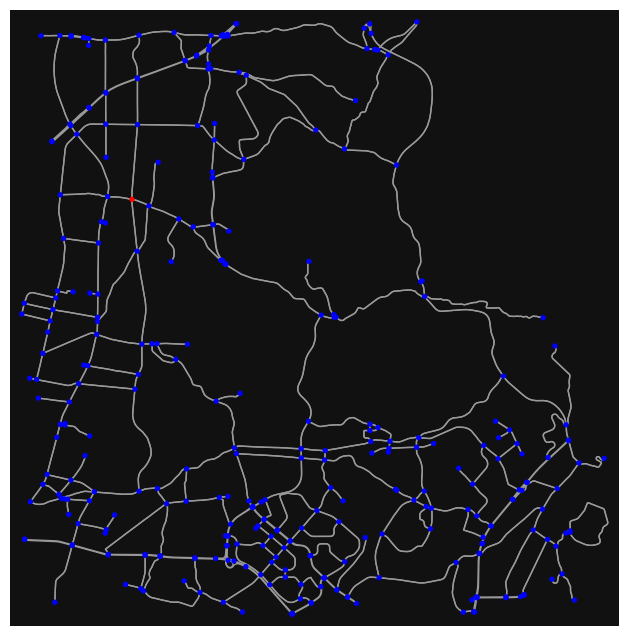

/tmp/ipykernel_5295/2203567140.py:68: UserWarning: The `folium` module has been deprecated and will be removed in a future release. You can generate and explore interactive web maps of graph nodes, edges, and/or routes automatically using GeoPandas.GeoDataFrame.explore instead, for example like: `ox.graph_to_gdfs(G, nodes=False).explore()`. See the OSMnx examples gallery for complete details and demonstrations.
  map_osm = ox.plot_graph_folium(ox.utils_graph.get_largest_component(G, strongly=True), edge_width=2)


In [6]:
import osmnx as ox
import folium
import pandas as pd
import numpy as np

# from IPython.display import display

# 峠道
graph = ox.graph_from_point(center_point=(35.334446, 136.990590)
                                , network_type='drive'
                                , dist=5000
                                , simplify=True
                                , custom_filter='["highway"~"tertiary|secondary|primary|trunk"]')

# グラフデータをGeoDataFrameに変換
gdf_nodes = ox.graph_to_gdfs(graph, nodes=True, edges=False)
gdf_edges = ox.graph_to_gdfs(graph, nodes=False, edges=True)

# エッジの長さから評価する。
lower_bound_meter = 100
upper_bound_meter = 1500
gdf_edges['evaluation'] = np.where(gdf_edges['length'] <= 100, 0,
                                   np.where(gdf_edges['length'] >= 1500, 1,
                                            (gdf_edges['length'] - 100) / (1500 - 100)))

G = ox.graph_from_gdfs(gdf_nodes, gdf_edges)

def get_nearest_node_by_coordinates(graph, latitude, longitude):
    nearest_node = ox.distance.nearest_nodes(
        graph, longitude, latitude, return_dist=False
    )
    return nearest_node

hakatasta_node = get_nearest_node_by_coordinates(G, 35.334446, 136.990590)

def get_coordinates_by_node_id(graph, node_id):
    node_data = graph.nodes[node_id]
    x = node_data['x']
    y = node_data['y']
    return x, y

a = get_coordinates_by_node_id(G, hakatasta_node)
node_colors = ['red' if node == hakatasta_node else 'blue' for node in graph.nodes]
ox.plot_graph(G, node_color=node_colors)

# 地図を表示する
map_osm = ox.plot_graph_folium(ox.utils_graph.get_largest_component(G, strongly=True), edge_width=2)

# evaluationが0以上のエッジの中心にマーカーを表示する
map_osm.add_child(folium.features.GeoJson(gdf_edges[gdf_edges['evaluation'] > 0.5].geometry.apply(lambda x: x.centroid).to_json()))